# Classyfing YouTube videos using tags, number of likes, comments and views


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals


import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

d:\miniconda3\envs\youtube-classification\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\miniconda3\envs\youtube-classification\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\miniconda3\envs\youtube-classification\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\miniconda3\envs\youtube-classification\lib\site-pack

In [2]:
from cvs_reader import load_dataframe
from dataframe_creator import create_seperate_columns

# Get dataframes with tags and category_id as columns
ca_csvpath = 'data/CAvideos.csv'
us_csvpath = 'data/USvideos.csv'
gb_csvpath = 'data/GBvideos.csv'

youtube_dfs = [load_dataframe(ca_csvpath, ['tags', 'category_id', 'likes', 'views', 'comment_count'])]
youtube_dfs += [load_dataframe(us_csvpath, ['tags', 'category_id', 'likes', 'views', 'comment_count'])]
youtube_dfs += [load_dataframe(gb_csvpath, ['tags', 'category_id', 'likes', 'views', 'comment_count'])]

# Concat three dataframes into one
youtube_df = pd.concat(youtube_dfs, ignore_index=True)
youtube_df = youtube_df.dropna()
youtube_df.head

<bound method NDFrame.head of                                                      tags  category_id  \
0       Eminem|Walk|On|Water|Aftermath/Shady/Interscop...           10   
1       plush|bad unboxing|unboxing|fan mail|idubbbztv...           23   
2       racist superman|rudy|mancuso|king|bach|racist|...           23   
3       ryan|higa|higatv|nigahiga|i dare you|idy|rhpc|...           24   
4       edsheeran|ed sheeran|acoustic|live|cover|offic...           10   
...                                                   ...          ...   
120741  Enrique Iglesias feat. Pitbull|MOVE TO MIAMI|P...           10   
120742  jacob sartorius|jacob|up with it|jacob sartori...           10   
120743  anne|marie|anne-marie|2002|two thousand and tw...           10   
120744  Eurovision Song Contest|2018|Lisbon|Cyprus|Ele...           24   
120745  Kyle|SuperDuperKyle|Ikuyo|2 Chainz|Sophia Blac...           10   

          likes     views  comment_count  
0        787425  17158579         1258

In [3]:
# Remove 'none' and duplicated values from dataframe
youtube_df = youtube_df[youtube_df['tags']!='[none]']
youtube_df = youtube_df.drop_duplicates(subset='tags')
youtube_df.head

<bound method NDFrame.head of                                                      tags  category_id  \
0       Eminem|Walk|On|Water|Aftermath/Shady/Interscop...           10   
1       plush|bad unboxing|unboxing|fan mail|idubbbztv...           23   
2       racist superman|rudy|mancuso|king|bach|racist|...           23   
3       ryan|higa|higatv|nigahiga|i dare you|idy|rhpc|...           24   
4       edsheeran|ed sheeran|acoustic|live|cover|offic...           10   
...                                                   ...          ...   
120589  5SOS|5 Seconds of Summer|No Roots|Cover|BBC|Ra...           10   
120593  Fox News Channel|FNC|Fox News|News|Latest News...           25   
120606  capitalfmofficial|capital|capital fm|capital r...           10   
120623  The Chainsmokers Somebody|Chainsmokers Somebod...           10   
120717  5-Minute Crafts|DIY|Do it yourself|crafts|truc...           26   

          likes     views  comment_count  
0        787425  17158579         1258

In [4]:
# delete some categories because of lack of data
to_delete = [2, 15, 19, 29, 30, 43]
for cat in to_delete:
    youtube_df = youtube_df[youtube_df.category_id != cat]
youtube_df.head()

,tags,category_id,likes,views,comment_count
0,Eminem|Walk|On|Water|Aftermath/Shady/Interscop...,10,787425,17158579,125882
1,plush|bad unboxing|unboxing|fan mail|idubbbztv...,23,127794,1014651,13030
2,racist superman|rudy|mancuso|king|bach|racist|...,23,146035,3191434,8181
3,ryan|higa|higatv|nigahiga|i dare you|idy|rhpc|...,24,132239,2095828,17518
4,edsheeran|ed sheeran|acoustic|live|cover|offic...,10,1634130,33523622,85067


In [5]:
from sklearn.utils import resample


# Spliting dataframe into several dfs based on category_id
dfs = [x for _, x in youtube_df.groupby('category_id')]

# getting 2000 samples from each category
resampled_dfs = []
for df in dfs:
    if df.shape[0] < 2000:
        resampled_dfs += [resample(df, n_samples=2000)]
    else:
        resampled_dfs += [df.sample(n=2000)]
    
youtube_df = pd.concat(resampled_dfs, axis=0, ignore_index=True)
youtube_df.head()

,tags,category_id,likes,views,comment_count
0,fossoyeur de films|cinéma|dracula|critique|chr...,1,10555,128452,629
1,infinity war|avengers|iron man|marvel|disney|s...,1,19759,158549,1951
2,Cinema|Trailer|Official|Movie|Film|I Feel Pret...,1,17203,1383357,849
3,ralphthemoviemaker,1,18100,210009,5090
4,peter rabbit|cinemasins|cinema sins|everything...,1,14491,462783,1703


In [6]:
# mapping remaining category numbers to ordered integers
new_categories_dict = {1:1, 10:2, 17:3, 20:4, 22:5, 23:6, 24:7, 25:8, 26:9, 27:10, 28:11}
reversed_new_categories_dict = {value:key for key, value in new_categories_dict.items()}
categories = youtube_df['category_id']
youtube_df['category_id'] = categories.map(new_categories_dict)
youtube_df.head()

,tags,category_id,likes,views,comment_count
0,fossoyeur de films|cinéma|dracula|critique|chr...,1,10555,128452,629
1,infinity war|avengers|iron man|marvel|disney|s...,1,19759,158549,1951
2,Cinema|Trailer|Official|Movie|Film|I Feel Pret...,1,17203,1383357,849
3,ralphthemoviemaker,1,18100,210009,5090
4,peter rabbit|cinemasins|cinema sins|everything...,1,14491,462783,1703


In [7]:
from vocab_handler import get_tags_frequency, get_tags_vocab, get_tags_vocab_as_dict


tag_frequency = get_tags_frequency(youtube_df['tags']) # returns tag as key and tag frequency as value
lists = sorted(tag_frequency.items())

lists[:10]

[('', 5),
 (" 'Gandarrappido: The Revenger Squad ", 0),
 (' 070118 💖', 1),
 (' 101217 💚', 0),
 (' 140118 💖', 1),
 (' 2018', 1),
 (' 210118 💖', 1),
 (' 220118 💖', 0),
 (' 251217 💘', 0),
 (' 261117 💚', 1)]

In [8]:
pruned_vocab = get_tags_vocab(tag_frequency, 50) #Returns tags vocab
vocab_di = get_tags_vocab_as_dict(pruned_vocab)

In [9]:
from sklearn.preprocessing import StandardScaler


# Perfroming normalization on integer datas
youtube_df['average'] = youtube_df[['likes', 'comment_count', 'views']].mean(axis=1)
scaler = StandardScaler()


youtube_df[['likes', 'comment_count', 'views', 'average']] = scaler.fit_transform(youtube_df[['likes', 'comment_count', 'views', 'average']])


In [10]:
max_of_tags = 96
 
# Create a dataframe by spliting each tag by '|'
youtube_df = create_seperate_columns(youtube_df, max_of_tags, 'tags')
youtube_df

,category_id,likes,views,comment_count,average,tag_0,tag_1,tag_2,tag_3,tag_4,...,tag_86,tag_87,tag_88,tag_89,tag_90,tag_91,tag_92,tag_93,tag_94,tag_95
0,1,-0.153575,-0.238757,-0.179381,-0.238120,fossoyeur de films,cinéma,dracula,critique,chronique,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
1,1,-0.030577,-0.222638,-0.078948,-0.217076,infinity war,avengers,iron man,marvel,disney,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
2,1,-0.064734,0.433317,-0.162668,0.415517,Cinema,Trailer,Official,Movie,Film,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
3,1,-0.052747,-0.195078,0.159524,-0.189651,ralphthemoviemaker,notags,notags,notags,notags,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
4,1,-0.100976,-0.059703,-0.097789,-0.062331,peter rabbit,cinemasins,cinema sins,everything wrong with,eww,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
5,1,-0.285888,-0.257397,-0.223293,-0.261579,The Royal Wedding Live with Cord & Tish,hbo,sketch,Will Ferrell,Molly Shannon,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
6,1,-0.213791,-0.229632,-0.209238,-0.231831,spaghett,somebody,toucha,knuckles,ugandan,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
7,1,1.666744,2.171574,0.943619,2.171553,Pixar,Disney,Disney Pixar,Pixar Movie,Animation,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
8,1,-0.292115,-0.288526,-0.217671,-0.291892,The View January 4 2018,The View,Hot topic,notags,notags,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
9,1,-0.280756,-0.280532,-0.217139,-0.283716,德国,青春,公路片,成长,K猫,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags


In [11]:
# One hot encoding tags
def one_hot(df, non_one_hot_columns):
    future_df = []
    col_row_dict = {}
    
    for i in range(0, 22000):
        for col in df.columns:
            if col in non_one_hot_columns:
                col_row_dict[col] = df[col][i]
            elif df[col][i] in pruned_vocab:
                    col_row_dict[df[col][i]] = 1.0
        future_df.append(col_row_dict)
        col_row_dict = {}
        
    return future_df

In [12]:
one_hot_list = one_hot(youtube_df, ['category_id', 'comment_count', 'likes', 'views', 'average'])
youtube_df = pd.DataFrame(one_hot_list)
youtube_df.fillna(0.0, inplace = True)
youtube_df

,category_id,likes,views,comment_count,average,humour,infinity war,avengers,marvel,disney,...,TED Education,TED,Teded,ovni,secureteam10,the verge,nozman,dr nozman,docteur nozman,stephen hawking
0,1,-0.153575,-0.238757,-0.179381,-0.238120,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,-0.030577,-0.222638,-0.078948,-0.217076,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,-0.064734,0.433317,-0.162668,0.415517,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,-0.052747,-0.195078,0.159524,-0.189651,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,-0.100976,-0.059703,-0.097789,-0.062331,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,-0.285888,-0.257397,-0.223293,-0.261579,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1,-0.213791,-0.229632,-0.209238,-0.231831,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1,1.666744,2.171574,0.943619,2.171553,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1,-0.292115,-0.288526,-0.217671,-0.291892,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1,-0.280756,-0.280532,-0.217139,-0.283716,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
from input_generator import generate_dataset


# Creating train,validation and test examples from tags and labels dataframe
(train_ds, train_lb), (val_ds, val_lb), (test_ds, test_lb) = generate_dataset(youtube_df, 'category_id')

In [14]:
hidden = 200
model = tf.keras.Sequential([
    layers.Dense(200,activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(300,activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(300,activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(150,activation='relu'),
    layers.Dense(100,activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(12, activation='softmax')])

nadam = keras.optimizers.Nadam(lr=0.00001)

model.compile(optimizer=nadam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              )

history = model.fit(train_ds.values, train_lb.values,
                    batch_size=32,
                    epochs=500,
                    validation_data=(val_ds.values, val_lb.values))


W0825 09:24:01.896393  8744 deprecation.py:506] From d:\miniconda3\envs\youtube-classification\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 13200 samples, validate on 4400 samples
Epoch 1/500
13200/13200 [==============================] - 5s 366us/sample - loss: 2.4848 - acc: 0.0895 - val_loss: 2.4786 - val_acc: 0.1243
Epoch 2/500
13200/13200 [==============================] - 4s 325us/sample - loss: 2.4787 - acc: 0.0964 - val_loss: 2.4720 - val_acc: 0.1425
Epoch 3/500
13200/13200 [==============================] - 4s 324us/sample - loss: 2.4707 - acc: 0.1009 - val_loss: 2.4648 - val_acc: 0.1514
Epoch 4/500
13200/13200 [==============================] - 4s 319us/sample - loss: 2.4641 - acc: 0.1060 - val_loss: 2.4563 - val_acc: 0.1593
Epoch 5/500
13200/13200 [==============================] - 4s 341us/sample - loss: 2.4545 - acc: 0.1120 - val_loss: 2.4459 - val_acc: 0.1525
Epoch 6/500
13200/13200 [==============================] - 5s 355us/sample - loss: 2.4469 - acc: 0.1086 - val_loss: 2.4342 - val_acc: 0.1484
Epoch 7/500
13200/13200 [==============================] - 4s 337us/sample - loss: 2.4379 - acc: 0.1166 -

13200/13200 [==============================] - 4s 312us/sample - loss: 1.4524 - acc: 0.5264 - val_loss: 1.2946 - val_acc: 0.5902
Epoch 59/500
13200/13200 [==============================] - 4s 311us/sample - loss: 1.4414 - acc: 0.5379 - val_loss: 1.2891 - val_acc: 0.5909
Epoch 60/500
13200/13200 [==============================] - 4s 311us/sample - loss: 1.4351 - acc: 0.5401 - val_loss: 1.2836 - val_acc: 0.5918
Epoch 61/500
13200/13200 [==============================] - 4s 315us/sample - loss: 1.4223 - acc: 0.5387 - val_loss: 1.2768 - val_acc: 0.5939
Epoch 62/500
13200/13200 [==============================] - 4s 314us/sample - loss: 1.4103 - acc: 0.5409 - val_loss: 1.2722 - val_acc: 0.5959
Epoch 63/500
13200/13200 [==============================] - 5s 355us/sample - loss: 1.4063 - acc: 0.5472 - val_loss: 1.2673 - val_acc: 0.5975
Epoch 64/500
13200/13200 [==============================] - 4s 336us/sample - loss: 1.3997 - acc: 0.5439 - val_loss: 1.2631 - val_acc: 0.5973
Epoch 65/500
13200/

13200/13200 [==============================] - 4s 340us/sample - loss: 1.1705 - acc: 0.6191 - val_loss: 1.1276 - val_acc: 0.6352
Epoch 116/500
13200/13200 [==============================] - 4s 331us/sample - loss: 1.1632 - acc: 0.6199 - val_loss: 1.1265 - val_acc: 0.6339
Epoch 117/500
13200/13200 [==============================] - 4s 324us/sample - loss: 1.1668 - acc: 0.6258 - val_loss: 1.1248 - val_acc: 0.6357
Epoch 118/500
13200/13200 [==============================] - 4s 317us/sample - loss: 1.1706 - acc: 0.6185 - val_loss: 1.1243 - val_acc: 0.6357
Epoch 119/500
13200/13200 [==============================] - 4s 329us/sample - loss: 1.1597 - acc: 0.6236 - val_loss: 1.1221 - val_acc: 0.6361
Epoch 120/500
13200/13200 [==============================] - 4s 336us/sample - loss: 1.1590 - acc: 0.6220 - val_loss: 1.1204 - val_acc: 0.6377
Epoch 121/500
13200/13200 [==============================] - 4s 335us/sample - loss: 1.1640 - acc: 0.6239 - val_loss: 1.1191 - val_acc: 0.6368
Epoch 122/500

13200/13200 [==============================] - 5s 358us/sample - loss: 1.0426 - acc: 0.6567 - val_loss: 1.0722 - val_acc: 0.6520
Epoch 173/500
13200/13200 [==============================] - 5s 354us/sample - loss: 1.0521 - acc: 0.6580 - val_loss: 1.0714 - val_acc: 0.6509
Epoch 174/500
13200/13200 [==============================] - 4s 311us/sample - loss: 1.0378 - acc: 0.6583 - val_loss: 1.0713 - val_acc: 0.6525
Epoch 175/500
13200/13200 [==============================] - 4s 321us/sample - loss: 1.0368 - acc: 0.6609 - val_loss: 1.0706 - val_acc: 0.6525
Epoch 176/500
13200/13200 [==============================] - 4s 323us/sample - loss: 1.0468 - acc: 0.6580 - val_loss: 1.0693 - val_acc: 0.6530
Epoch 177/500
13200/13200 [==============================] - 4s 332us/sample - loss: 1.0226 - acc: 0.6641 - val_loss: 1.0701 - val_acc: 0.6539
Epoch 178/500
13200/13200 [==============================] - 4s 336us/sample - loss: 1.0252 - acc: 0.6616 - val_loss: 1.0694 - val_acc: 0.6541
Epoch 179/500

13200/13200 [==============================] - 4s 315us/sample - loss: 0.9633 - acc: 0.6808 - val_loss: 1.0495 - val_acc: 0.6623
Epoch 230/500
13200/13200 [==============================] - 4s 313us/sample - loss: 0.9524 - acc: 0.6859 - val_loss: 1.0500 - val_acc: 0.6623
Epoch 231/500
13200/13200 [==============================] - 4s 315us/sample - loss: 0.9535 - acc: 0.6859 - val_loss: 1.0502 - val_acc: 0.6609
Epoch 232/500
13200/13200 [==============================] - 4s 318us/sample - loss: 0.9569 - acc: 0.6844 - val_loss: 1.0495 - val_acc: 0.6620
Epoch 233/500
13200/13200 [==============================] - 4s 314us/sample - loss: 0.9570 - acc: 0.6835 - val_loss: 1.0487 - val_acc: 0.6639
Epoch 234/500
13200/13200 [==============================] - 4s 318us/sample - loss: 0.9502 - acc: 0.6855 - val_loss: 1.0488 - val_acc: 0.6627
Epoch 235/500
13200/13200 [==============================] - 4s 320us/sample - loss: 0.9479 - acc: 0.6881 - val_loss: 1.0484 - val_acc: 0.6636
Epoch 236/500

13200/13200 [==============================] - 4s 313us/sample - loss: 0.8985 - acc: 0.7015 - val_loss: 1.0403 - val_acc: 0.6702
Epoch 287/500
13200/13200 [==============================] - 4s 311us/sample - loss: 0.8929 - acc: 0.7042 - val_loss: 1.0407 - val_acc: 0.6702
Epoch 288/500
13200/13200 [==============================] - 4s 312us/sample - loss: 0.8928 - acc: 0.7035 - val_loss: 1.0412 - val_acc: 0.6684
Epoch 289/500
13200/13200 [==============================] - 4s 314us/sample - loss: 0.8932 - acc: 0.7035 - val_loss: 1.0415 - val_acc: 0.6698
Epoch 290/500
13200/13200 [==============================] - 4s 314us/sample - loss: 0.8991 - acc: 0.6973 - val_loss: 1.0417 - val_acc: 0.6695
Epoch 291/500
13200/13200 [==============================] - 4s 313us/sample - loss: 0.8939 - acc: 0.7019 - val_loss: 1.0409 - val_acc: 0.6700
Epoch 292/500
13200/13200 [==============================] - 4s 314us/sample - loss: 0.8890 - acc: 0.7066 - val_loss: 1.0412 - val_acc: 0.6707
Epoch 293/500

13200/13200 [==============================] - 4s 332us/sample - loss: 0.8550 - acc: 0.7111 - val_loss: 1.0405 - val_acc: 0.6764
Epoch 344/500
13200/13200 [==============================] - 4s 319us/sample - loss: 0.8540 - acc: 0.7164 - val_loss: 1.0409 - val_acc: 0.6745
Epoch 345/500
13200/13200 [==============================] - 4s 314us/sample - loss: 0.8485 - acc: 0.7171 - val_loss: 1.0398 - val_acc: 0.6759
Epoch 346/500
13200/13200 [==============================] - 4s 323us/sample - loss: 0.8458 - acc: 0.7187 - val_loss: 1.0414 - val_acc: 0.6759
Epoch 347/500
13200/13200 [==============================] - 4s 317us/sample - loss: 0.8467 - acc: 0.7162 - val_loss: 1.0410 - val_acc: 0.6759
Epoch 348/500
13200/13200 [==============================] - 4s 314us/sample - loss: 0.8488 - acc: 0.7173 - val_loss: 1.0410 - val_acc: 0.6761
Epoch 349/500
13200/13200 [==============================] - 4s 314us/sample - loss: 0.8524 - acc: 0.7148 - val_loss: 1.0417 - val_acc: 0.6755
Epoch 350/500

13200/13200 [==============================] - 5s 348us/sample - loss: 0.8151 - acc: 0.7230 - val_loss: 1.0502 - val_acc: 0.6791
Epoch 401/500
13200/13200 [==============================] - 4s 298us/sample - loss: 0.8086 - acc: 0.7302 - val_loss: 1.0502 - val_acc: 0.6800
Epoch 402/500
13200/13200 [==============================] - 4s 300us/sample - loss: 0.8126 - acc: 0.7289 - val_loss: 1.0516 - val_acc: 0.6814
Epoch 403/500
13200/13200 [==============================] - 4s 296us/sample - loss: 0.8157 - acc: 0.7258 - val_loss: 1.0496 - val_acc: 0.6811
Epoch 404/500
13200/13200 [==============================] - 4s 300us/sample - loss: 0.8118 - acc: 0.7280 - val_loss: 1.0499 - val_acc: 0.6809
Epoch 405/500
13200/13200 [==============================] - 4s 297us/sample - loss: 0.8105 - acc: 0.7298 - val_loss: 1.0504 - val_acc: 0.6800
Epoch 406/500
13200/13200 [==============================] - 4s 302us/sample - loss: 0.8061 - acc: 0.7304 - val_loss: 1.0515 - val_acc: 0.6795
Epoch 407/500

13200/13200 [==============================] - 4s 297us/sample - loss: 0.7848 - acc: 0.7383 - val_loss: 1.0610 - val_acc: 0.6857
Epoch 458/500
13200/13200 [==============================] - 4s 295us/sample - loss: 0.7765 - acc: 0.7363 - val_loss: 1.0627 - val_acc: 0.6852
Epoch 459/500
13200/13200 [==============================] - 4s 295us/sample - loss: 0.7853 - acc: 0.7366 - val_loss: 1.0620 - val_acc: 0.6855
Epoch 460/500
13200/13200 [==============================] - 4s 316us/sample - loss: 0.7814 - acc: 0.7372 - val_loss: 1.0626 - val_acc: 0.6855
Epoch 461/500
13200/13200 [==============================] - 4s 326us/sample - loss: 0.7809 - acc: 0.7386 - val_loss: 1.0619 - val_acc: 0.6850
Epoch 462/500
13200/13200 [==============================] - 4s 327us/sample - loss: 0.7895 - acc: 0.7336 - val_loss: 1.0621 - val_acc: 0.6857
Epoch 463/500
13200/13200 [==============================] - 4s 329us/sample - loss: 0.7788 - acc: 0.7389 - val_loss: 1.0631 - val_acc: 0.6852
Epoch 464/500

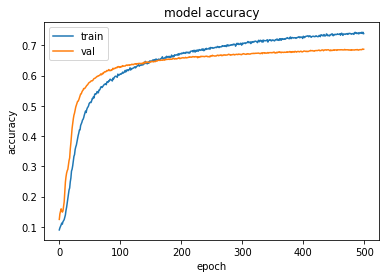

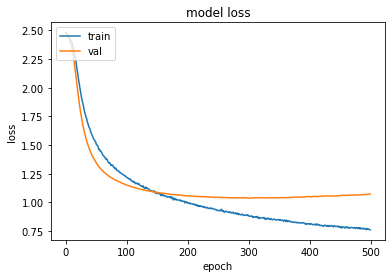

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
results = model.evaluate(test_ds, test_lb)

print(results)

4400/4400 [==============================] - 0s 64us/sample - loss: 1.1118 - acc: 0.6902
[1.1117712192101912, 0.69022727]


In [21]:
from sklearn.metrics import classification_report

predictions = model.predict(test_ds)
print(classification_report(test_lb, np.argmax(predictions, axis=1)))

              precision    recall  f1-score   support

           1       0.83      0.59      0.69       432
           2       0.65      0.80      0.72       411
           3       0.88      0.81      0.84       406
           4       0.73      0.77      0.75       404
           5       0.42      0.40      0.41       374
           6       0.79      0.65      0.71       410
           7       0.44      0.42      0.43       426
           8       0.60      0.80      0.68       376
           9       0.66      0.82      0.73       396
          10       0.88      0.82      0.85       369
          11       0.84      0.75      0.79       396

    accuracy                           0.69      4400
   macro avg       0.70      0.69      0.69      4400
weighted avg       0.70      0.69      0.69      4400



In [17]:
from tag_handler import get_category_title_dict


cat_tit_dict = get_category_title_dict('data/json/CA_category_id.json')
cat_tit_dict.update(get_category_title_dict('data/json/US_category_id.json'))
cat_tit_dict.update(get_category_title_dict('data/json/GB_category_id.json'))

In [19]:
for i in range(30, 40):
    y_pred = reversed_new_categories_dict[np.argmax(predictions[i])]
    label = reversed_new_categories_dict[test_lb.values[i]]
    print('""""""""""""""""""""""""""""""""""""""""""""""""')
    print('predict:{}'.format(cat_tit_dict[str(y_pred)]))
    print('true label:{}'.format(cat_tit_dict[str(label)]))

""""""""""""""""""""""""""""""""""""""""""""""""
predict:Science & Technology
true label:Science & Technology
""""""""""""""""""""""""""""""""""""""""""""""""
predict:News & Politics
true label:News & Politics
""""""""""""""""""""""""""""""""""""""""""""""""
predict:Film & Animation
true label:Film & Animation
""""""""""""""""""""""""""""""""""""""""""""""""
predict:Gaming
true label:Gaming
""""""""""""""""""""""""""""""""""""""""""""""""
predict:Science & Technology
true label:Science & Technology
""""""""""""""""""""""""""""""""""""""""""""""""
predict:Science & Technology
true label:Science & Technology
""""""""""""""""""""""""""""""""""""""""""""""""
predict:Sports
true label:Sports
""""""""""""""""""""""""""""""""""""""""""""""""
predict:Science & Technology
true label:Science & Technology
""""""""""""""""""""""""""""""""""""""""""""""""
predict:Howto & Style
true label:Howto & Style
""""""""""""""""""""""""""""""""""""""""""""""""
predict:Sports
true label:Film & Animation
